# 添加MWPC

## 利用map时间排序

```c++
int fillMapMWPC(TTree *mtree) {
	mapMWPC.clear();
	printf("filling mwpc map   0%%");
	fflush(stdout);
	Long64_t nentry = mtree->GetEntries();
	Long64_t nentry100 = nentry / 100;
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		mtree->GetEntry(jentry);
		mapMWPC.insert(make_pair(rmt, rme));

		if (jentry % nentry100 == 0) {
			printf("\b\b\b\b%3lld%%", (jentry+1)/nentry100);
			fflush(stdout);
		}
	}
	printf("\b\b\b\b100%%\n");
	return 0;
}

```

map中前20个元素

         i         energy           time
         0       3.000000       78196010
         1   32763.000000      259521960
         2   32726.000000      574208200
         3      24.000000      750230460
         4      15.000000     1086207510
         5      24.000000     1363535160
         6   32749.000000     1364841100
         7       5.000000     1426179500
         8      34.000000     1495511510
         9       8.000000     1731485990
        10      17.000000     1911503110
        11   32761.000000     2078145400
        12   32765.000000     2096823800
        13       4.000000     2139483500
        14      36.000000     2208815270
        15      61.000000     2332796450
        16      49.000000     2432797710
        17   32757.000000     2495441750
        18   32764.000000     2568770250
        19      52.000000     2662083300
        
        
## 搜索DSSD和MWPC的符合时间窗

```c++
int searchWindow(TTree *atree, ULong64_t tw = 100000) {
	TH1I *hdt = new TH1I("hdt", "alpha-mwpc distribution(ns)", 20000, -100000, 100000);
	printf("generating hdt   0%%");
	fflush(stdout);
	Long64_t nentry = atree->GetEntries();
	Long64_t nentry100 = nentry / 100;
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		atree->GetEntry(jentry);

		for (int i = 0; i != ahit; ++i) {
			auto mi = mapMWPC.lower_bound(at[i]-tw);
			for (; mi != mapMWPC.end(); ++mi) {
				if (mi->first >= at[i]+tw) break;
				int dt = at[i] - mi->first;
				hdt->Fill(dt);
			}
		}

		if (jentry % nentry100 == 0) {
			printf("\b\b\b\b%3lld%%", (jentry+1)/nentry100);
			fflush(stdout);
		}
	}
	printf("\b\b\b\b100%%\n");

	hdt->Write();
	return 0;
}
```

In [1]:
TFile *amf = new TFile("../data/am.root", "read");
TFile *mf = new TFile("../data/mwpc.root", "read");
TTree *mtree = (TTree*)mf->Get("tree");
TTree *amtree = (TTree*)amf->Get("tree");
TCanvas *c1 = new TCanvas;
amf->ls();

TFile**		../data/am.root	
 TFile*		../data/am.root	
  OBJ: TTree	tree	tree of dssd and mwpc : 0 at: 0x7f1e045d9ab0
  KEY: TH1I	hdt;1	alpha-mwpc distribution(ns)
  KEY: TH1I	hemc;1	energy of conincident mwpc
  KEY: TH1I	hfme;1	found mwpc energy numbers
  KEY: TTree	tree;1	tree of dssd and mwpc


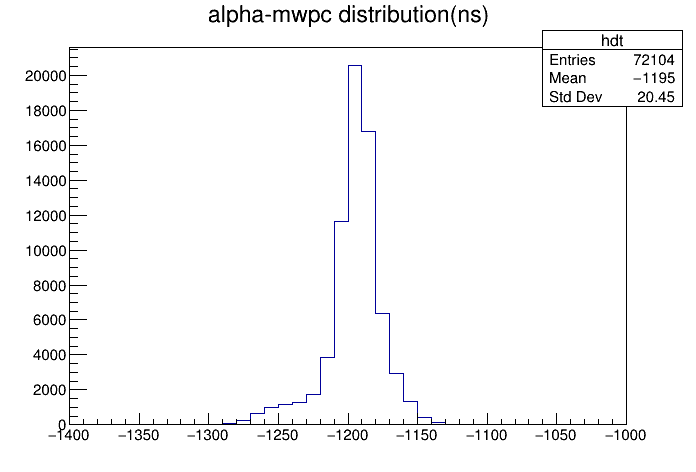

In [2]:
TH1I *hdt = (TH1I*)amf->Get("hdt");
hdt->GetXaxis()->SetRangeUser(-1400, -1000);
hdt->Draw();
c1->Draw();

符合时间窗宽度为100ns，offset为-1200，由此进行DSSD和MWPC的符合

## 符合

```c++
int awCorrelation(TTree *atree, TTree *opt, ULong64_t tw, ULong64_t toff) {
	TH1I *hemc = new TH1I("hemc", "energy of conincident mwpc", 3500, 0, 35000);
	TH1I *hfme = new TH1I("hfme", "found mwpc energy numbers", 10, 0, 10);
	printf("dssd mwpc correlation   0%%");
	fflush(stdout);
	Long64_t nentry = atree->GetEntries();
	Long64_t nentry100 = nentry / 100;
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		atree->GetEntry(jentry);
		for (int i = 0; i != chit; ++i) {
			ce[i] = ae[i];
			ct[i] = at[i];
			cfStrip[i] = afStrip[i];
			cbStrip[i] = abStrip[i];
			cfe[i] = afe[i];
			cbe[i] = abe[i];
			cme[i] = -1.0;
		}

		int foundme = 0;
		auto mi = mapMWPC.lower_bound(at[0]+toff-tw);
		for (; mi != mapMWPC.end(); ++mi) {
			if (mi->first >= at[0]+toff+tw) break;
			++foundme;
			for (int i = 0; i != chit; ++i) {
				cme[i] = mi->second;
			}
			opt->Fill();
			hemc->Fill(mi->second);
		}
		hfme->Fill(foundme);

		if (!foundme) {
			opt->Fill();
		}

		if (jentry % nentry100 == 0) {
			printf("\b\b\b\b%3lld%%", (jentry+1)/nentry100);
			fflush(stdout);
		}
	}
	printf("\b\b\b\b100%%\n");

	hemc->Write();
	hfme->Write();
	opt->Write();
	return 0;
}
```

对于每一个DSSD的事件，符合上的MWPC事件数分布为

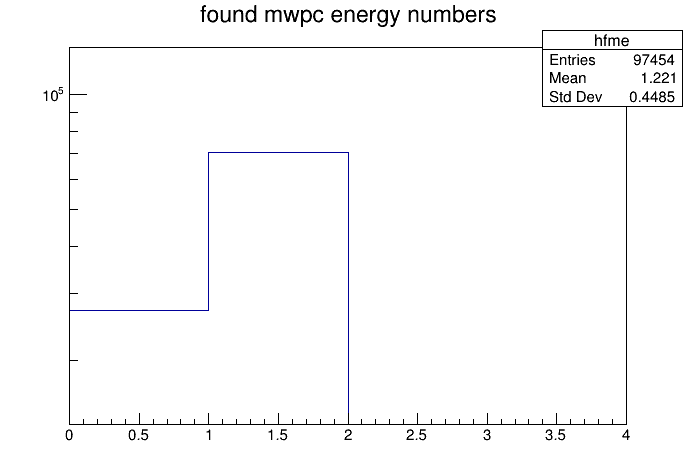

In [3]:
TH1I *hfme = (TH1I*)amf->Get("hfme");
hfme->GetXaxis()->SetRangeUser(0, 4);
hfme->Draw();
c1->SetLogy();
c1->Draw();

大部分事件是符合上一个，小部分没有符合上，是合理的，并且说明所开的符合时间窗是合理的。

### 与DSSD符合的MWPC能量谱
红色代表符合事件，蓝色代表所有事件（未进行符合）

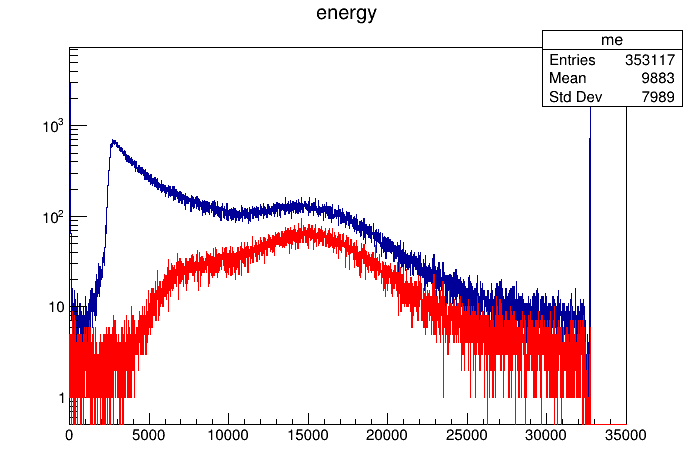

In [4]:
mtree->Draw("energy>>me(3500, 0, 35000)");
TH1I *hemc = (TH1I*)amf->Get("hemc");
hemc->SetLineColor(kRed);
hemc->Draw("same");
c1->SetLogy();
c1->Draw();

### 与MWPC符合的DSSD能量谱
红色代表符合，蓝色代表所有（未进行符合）

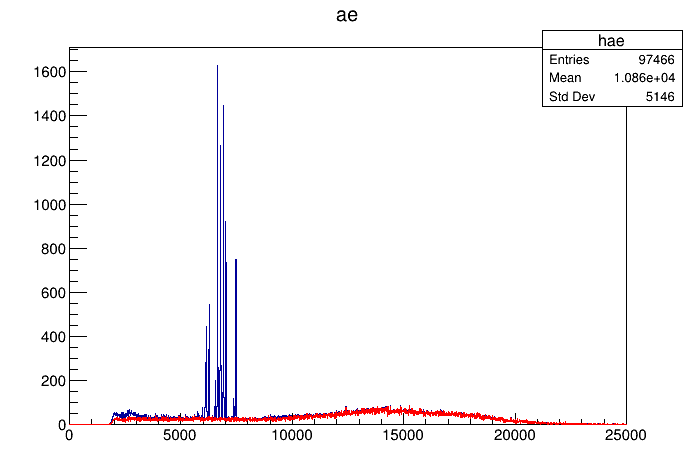

In [5]:
amtree->Draw("ae>>hae(2500, 0, 25000)", "", "goff");
TH1 *hae = (TH1*)gDirectory->Get("hae"); 
amtree->Draw("ae>>haec(2500, 0, 25000)", "me > 0", "goff");
TH1 *haec = (TH1*)gDirectory->Get("haec");
hae->Draw();
haec->SetLineColor(kRed);
haec->Draw("same");
c1->SetLogy(0);
c1->Draw();